Code for figures in section 2.2 and some stuff not included

In [1]:
import numpy as np
from scipy.stats import norm
from scipy import linalg
from scipy.stats import semicircular
from scipy.special import bernoulli  # for setting2
from math import factorial  # for setting2

rng = np.random.default_rng(seed=42)

In [18]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

Selection of sigmoid denoisers  (forms similar to tanh, modified to be in range (-1,1)):
- Logistic $\frac{2}{1+e^{-mx/s}}-1$ (might be same as tanh when exponent multiplied by 2)
- Arctan $\frac{2}{\pi}\arctan (mx/s)$
- Standard Normal CDF $2F(\frac{mx}{s})-1$
- Nameless? $\frac{mx/s}{(1+|mx/s|^k)^{1/k}}$ with parameter k

For all of these, I can play around with m and s to make it similar to $tanh(mx/s)$ and see what I get

In [3]:
## denoisers
denoiser_tanh = lambda x, m, s: np.tanh(m*x/s)
denoiser_arctan = lambda x, m, s: 2*np.arctan(2*m*x/s)/np.pi  # compared to tanh, bigger magnitude close to 0, smaller when further away
denoiser_stdnormalcdf = lambda x, m, s: 2*norm.cdf(1.2*m*x/s)-1 # compared to tanh, slightly smaller magnitude close to 0, bigger when further away
denoiser_nameless = lambda x, m, s: (m*x/s)/(1+np.abs(m*x/s)**3)**(1/3) # compared to tanh, slightly bigger magnitude around |1|+-0.4

In [4]:
## average derivatives
derivative_tanh = lambda x, m, s: m/s * (1-np.mean(np.tanh(m*x/s)**2))
derivative_arctan = lambda x, m, s: np.mean(4*m*s/(np.pi*(4*m**2 * x**2 + s**2)))
derivative_stdnormalcdf = lambda x, m, s: np.mean(3*2**(3/2)*np.exp(-18*m**2 * x**2/(25*s**2))/(5*np.sqrt(np.pi)*s))
derivative_nameless = lambda x, m, s: np.mean(m / (s* (m**2 * np.abs(m) * x**2 * np.abs(x) / (s**2 * np.abs(s)) +1)**(4/3)))

In [5]:
# Priors on signal
rademacher = lambda n: rng.choice([-1, 1], size=n)
uniform = lambda n: rng.uniform(-1, 1, size=n)
binomial = lambda n: rng.binomial(10, .5, size=n)
test = lambda n: rng.choice([1, 2, 3], size=n)

In [6]:
# Normalized Squared Correlation
nsc = lambda x, y: np.dot(x, y) ** 2 / np.linalg.norm(x) ** 2 / np.linalg.norm(y) ** 2

In [7]:
def run_amp_symmetric_mp(X, u, niter, denoiser, derivative, c):
    n = len(u)
    # Initialization with PCA
    D, V = linalg.eigh(X)  # sum of symmetric matrices is symmetric, so we can use eigh instead of eig
    if not np.isrealobj(V):
        raise Exception("Eigenvalues are not real. Need to get their real part.")
    largest_eigval_ind = np.argmax(D)
    v0 = V[:, largest_eigval_ind]
    u_init = np.sqrt(n) * v0

    # alpha1 is the estimate of the SNR \alpha obtained from the
    # largest eigenvalue of the data matrix X
    largest_eigval = np.max(D)
    alpha1 = (largest_eigval + 1 - c + np.sqrt((largest_eigval + 1 - c) ** 2 - 4 * largest_eigval)) / 2

    # To keep track during iterations
    uAMP = dict()
    fAMP = dict()
    muSE = dict()  # SE = state evolution
    sigmaSE = dict()
    avgder = dict()
    scal = dict()  # normalized squared correlation

    # first iteration of AMP with PCA initialization
    uAMP[1] = u_init
    scal[1] = nsc(uAMP[1], u)
    print(f"Iteration 1, scal={scal[1]}")

    # estimate SE parameters from their limit expressions
    # (using the value of \alpha obtained from the data)
    muSE[1] = alpha1 * np.sqrt(1 - c / (alpha1 - 1) ** 2)
    sigmaSE[1] = c * alpha1 ** 2 / (alpha1 - 1) ** 2

    # computation of the memory coefficients
    b11 = c * alpha1 / (alpha1 - 1)

    # iterate f^1
    fAMP[1] = X @ uAMP[1] - b11 * uAMP[1]

    # iterate u^2
    uAMP[2] = denoiser(fAMP[1], muSE[1], sigmaSE[1])

    # normalized squared correlation between u^2 and the signal
    scal[2] = nsc(uAMP[2], u)
    print(f"Iteration 2, scal={scal[2]}")

    # average of the derivate of the denoiser u_2
    avgder[1] = derivative(fAMP[1], muSE[1], sigmaSE[1])

    for jj in range(2, niter):
        # Go back to posterior mean for the last iteration
        if jj==niter-1:
            denoiser = denoiser_tanh
            derivative = derivative_tanh

        # computation of the memory coefficients
        b = dict()
        b[jj] = c
        for ii in range(jj-1):
            b[jj - ii - 1] = c * np.prod([avgder[_] for _ in range(jj - ii - 1, jj)], axis=0)
        b[1] = b[1] * alpha1 / (alpha1 - 1)

        # iterate f^t
        fAMP[jj] = X @ uAMP[jj] - np.sum([b[_] * uAMP[_] for _ in range(1, jj + 1)], axis=0)

        # estimation of \sigma_{t, t} from the data
        # NOTE: No idea what is happening here
        M = np.zeros(shape=(jj - 1, jj - 1))

        for i1 in range(1, jj):
            for i2 in range(1, jj):
                # To remain consistent with original code, I keep almost everything the same
                # but I have to be careful about array indexing
                M[i1 - 1, i2 - 1] = c * np.prod([avgder[_] for _ in range(jj - i1 + 1, jj)], axis=0) \
                                    * np.prod([avgder[_] for _ in range(jj - i2 + 1, jj)], axis=0) * (
                                            uAMP[jj - i1 + 1].T @ uAMP[jj - i2 + 1]) / n

        M1 = np.zeros(shape=(1, jj - 1))

        for i2 in range(1, jj):
            M1[0, i2 - 1] = c / (alpha1 - 1) * np.prod([avgder[_] for _ in range(1, jj)], axis=0) \
                            * np.prod([avgder[_] for _ in range(jj - i2 + 1, jj)], axis=0) * (
                                    fAMP[1].T @ uAMP[jj - i2 + 1]) / n

        M2 = c / (alpha1 - 1) ** 2 * (np.prod([avgder[_] for _ in range(1, jj)], axis=0)) ** 2 \
             * (fAMP[1].T @ fAMP[1]) / n

        sigmaSE[jj] = np.sum(M) + 2 * np.sum(M1) + M2

        # given \sigma_{t, t}, \mu_t can be estimated from the norm of
        # the iterate f^t
        # NOTE: Follows from Unifying tutorial remark 3.3
        muSE[jj] = np.sqrt(abs(np.sum(fAMP[jj] ** 2) / n - sigmaSE[jj]))

        # iterate u^{t+1}
        uAMP[jj + 1] = denoiser(fAMP[jj], muSE[jj], sigmaSE[jj])

        # average of the derivate of the denoiser u^{t+1}
        avgder[jj] = derivative(fAMP[jj], muSE[jj], sigmaSE[jj])

        # normalized squared correlation between u^{t+1} and the signal
        scal[jj + 1] = nsc(uAMP[jj + 1], u)
        print(f"Iteration {jj + 1}, scal={scal[jj + 1]}")

    return {"u":u, "uAMP":uAMP, "fAMP": fAMP, "muSE":muSE, "sigmaSE":sigmaSE, "scal":scal}

In [8]:
def symmetric_mp_exp(signal_prior, n, alphas: list[int], ntrials, niter, denoisers):
    c = 2  # MP parameter
    print("Starting Experiment: Symmetric AMP with M-P noise")

    denoiser_list = {"tanh":denoiser_tanh, "arctan":denoiser_arctan, "normal":denoiser_stdnormalcdf, "nameless": denoiser_nameless}
    derivative_list = {"tanh":derivative_tanh, "arctan":derivative_arctan, "normal":derivative_stdnormalcdf, "nameless": derivative_nameless}

    data = dict()

    for i in range(1, ntrials+1):
        data[i] = dict()

        u = signal_prior(n)
        u = u*(np.sqrt(n)/np.linalg.norm(u))

        # The noise matrix W follows a Marchenko-Pastur distribution
        p = n * c
        A = rng.normal(size=(n, p))
        W = 1 / n * (A @ A.T)
        for alpha in alphas:
            data[i][alpha] = dict()
            X = alpha / n * np.outer(u, u) + W
            for d in denoisers:
                print(f"Trial {i}, alpha {alpha}, {d} denoiser")
                data[i][alpha][d] = run_amp_symmetric_mp(X, u, niter, denoiser_list[d], derivative_list[d], c)
    return data

In [27]:
def run_amp_symmetric_unif(X, u, niter, denoiser, derivative):
    # Computation of the limit free cumulants
    max_it = niter
    bernoulli_nums = bernoulli(2 * max_it)  # starting at 0, ending at 2max_it (inclusive)
    free_cumulants = {n: bernoulli_nums[n] / factorial(n) if n % 2 == 0 else 0 for n in range(1, 2 * max_it + 1)}

    # if niter is too large, set the corresponding free cumulant to 0
    # (the formula above doesn't work well when niter is large)
    if niter > 100:
        free_cumulants.update({n: 0 for n in range(200, 2 * max_it + 1)})


    n = len(u)
    # Initialization with PCA
    D, V = linalg.eigh(X)  # sum of symmetric matrices is symmetric, so we can use eigh instead of eig
    if not np.isrealobj(V):
        raise Exception("Eigenvalues are not real. Need to get their real part.")
    largest_eigval_ind = np.argmax(D)
    v0 = V[:, largest_eigval_ind]
    u_init = np.sqrt(n) * v0

    # alpha1 is the estimate of the SNR \alpha obtained from the
    # largest eigenvalue of the data matrix X
    largest_eigval = np.max(D)
    if largest_eigval > (0.5 + 10 ** (-6)):
        alpha1 = 1 / np.log((2 * largest_eigval + 1) / (2 * largest_eigval - 1))
    else:
        # if we are too close to the PCA threshold, the formula above
        # doesn't work well. Thus, we just set alpha1 to be some
        # small value (e.g., 0.05)
        alpha1 = 0.05

    # To keep track during iterations
    uAMP = dict()
    fAMP = dict()
    muSE = dict()  # SE = state evolution
    sigmaSE = dict()
    avgder = dict()
    scal = dict()  # normalized squared correlation

    # first iteration of AMP with PCA initialization
    uAMP[1] = u_init
    scal[1] = nsc(uAMP[1], u)
    print(f"Iteration 1, scal={scal[1]}")

    # estimate SE parameters from their limit expressions
    # (using the value of \alpha obtained from the data)
    muSE[1] = alpha1 * np.sqrt(1 / alpha1 ** 2 * (1 - np.tanh(1 / (2 * alpha1)) ** 2 / (4 * np.tanh(1 / (2 * alpha1)) ** 2)))
    sigmaSE[1] = alpha1 ** 2 * (1 - 1 / alpha1 ** 2 * (1 - np.tanh(1 / (2 * alpha1)) ** 2 / (4 * np.tanh(1 / (2 * alpha1)) ** 2)))

    # computation of the memory coefficients
    b11 = 1 / (2 * np.tanh(1 / (2 * alpha1))) - alpha1

    # iterate f^1
    fAMP[1] = X @ uAMP[1] - b11 * uAMP[1]

    # iterate u^2
    uAMP[2] = denoiser(fAMP[1], muSE[1], sigmaSE[1])

    # normalized squared correlation between u^2 and the signal
    scal[2] = nsc(uAMP[2], u)
    print(f"Iteration 2, scal={scal[2]}")

    # average of the derivate of the denoiser u_2
    avgder[1] = derivative(fAMP[1], muSE[1], sigmaSE[1])

    for jj in range(2, niter):
        # Go back to posterior mean for the last iteration
        if jj==niter-1:
            denoiser = denoiser_tanh
            derivative = derivative_tanh

        # computation of the memory coefficients
        b = dict()
        b[jj] = 0
        for ii in range(jj - 2):
            b[jj - ii - 1] = free_cumulants[ii + 2] * np.prod([avgder[_] for _ in range(jj - ii - 1, jj)], axis=0)
        b[1] = alpha1 ** (jj - 1) * (
                b11 - np.sum([free_cumulants[_ + 1] / (alpha1 ** _) for _ in range(jj - 1)])) \
               * np.prod([avgder[_] for _ in range(1, jj)], axis=0)

        # iterate f^t
        fAMP[jj] = X @ uAMP[jj] - np.sum([b[_] * uAMP[_] for _ in range(1, jj + 1)], axis=0)

        # estimation of \sigma_{t, t} from the data
        # NOTE: No idea what is happening here
        M = np.zeros(shape=(jj - 1, jj - 1))

        for i1 in range(1, jj):
            for i2 in range(1, jj):
                # To remain consistent with original code, I keep almost everything the same
                # but I have to be careful about array indexing
                M[i1 - 1, i2 - 1] = free_cumulants[i1 + i2] * np.prod(
                            [avgder[_] for _ in range(jj - i1 + 1, jj)], axis=0) \
                                            * np.prod([avgder[_] for _ in range(jj - i2 + 1, jj)], axis=0) * (
                                                    uAMP[jj - i1 + 1].T @ uAMP[jj - i2 + 1]) / n

        M1 = np.zeros(shape=(1, jj - 1))

        for i2 in range(1, jj):
            M1[0, i2 - 1] = alpha1 ** (jj + i2 - 2) \
                                    * (b11 - np.sum(
                        [free_cumulants[_ + 1] / (alpha1 ** _) for _ in range(jj + i2 - 1)])) \
                                    * np.prod([avgder[_] for _ in range(1, jj)], axis=0) \
                                    * np.prod([avgder[_] for _ in range(jj - i2 + 1, jj)]) \
                                    * np.dot(fAMP[1], uAMP[jj - i2 + 1]) / n

        extrav = np.zeros(shape=(1, jj - 1))

        for i1 in range(1, jj):
            extrav[0, i1 - 1] = (b11 - np.sum([free_cumulants[_ + 1] / (alpha1 ** _) for _ in range(i1)]))

        extrac = np.zeros(shape=(jj - 1, jj - 1))

        for i1 in range(1, jj):
            for i2 in range(1, jj):
                extrac[i1 - 1, i2 - 1] = free_cumulants[i1 + i2] / alpha1 ** (i1 + i2 - 2)

        M2 = alpha1 ** (2 * jj - 4) * (
                        alpha1 ** 2 + (np.tanh(1 / (2 * alpha1)) ** 2 - 1) / (4 * np.tanh(1 / (2 * alpha1)) ** 2) -
                        2 * alpha1 * np.sum(extrav) + np.sum(extrac)) \
                     * np.prod([avgder[_] for _ in range(1, jj)], axis=0) ** 2 \
                     * np.dot(fAMP[1], fAMP[1]) / n

        sigmaSE[jj] = np.sum(M) + 2 * np.sum(M1) + M2

        # given \sigma_{t, t}, \mu_t can be estimated from the norm of
        # the iterate f^t
        # NOTE: Follows from Unifying tutorial remark 3.3
        muSE[jj] = np.sqrt(abs(np.sum(fAMP[jj] ** 2) / n - sigmaSE[jj]))

        # iterate u^{t+1}
        uAMP[jj + 1] = denoiser(fAMP[jj], muSE[jj], sigmaSE[jj])

        # average of the derivate of the denoiser u^{t+1}
        avgder[jj] = derivative(fAMP[jj], muSE[jj], sigmaSE[jj])

        # normalized squared correlation between u^{t+1} and the signal
        scal[jj + 1] = nsc(uAMP[jj + 1], u)
        print(f"Iteration {jj + 1}, scal={scal[jj + 1]}")

    return {"u":u, "uAMP":uAMP, "fAMP": fAMP, "muSE":muSE, "sigmaSE":sigmaSE, "scal":scal}

In [28]:
def symmetric_unif_exp(signal_prior, n, alphas: list[float], ntrials, niter, denoisers: list[str]):
    print("Starting Experiment: Symmetric AMP with Unif noise")

    denoiser_list = {"tanh":denoiser_tanh, "arctan":denoiser_arctan, "normal":denoiser_stdnormalcdf, "nameless": denoiser_nameless}
    derivative_list = {"tanh":derivative_tanh, "arctan":derivative_arctan, "normal":derivative_stdnormalcdf, "nameless": derivative_nameless}

    data = dict()

    for i in range(1, ntrials+1):
        data[i] = dict()

        u = signal_prior(n)
        u = u*(np.sqrt(n)/np.linalg.norm(u))

        # The eigenvalues of the noise are i.i.d. and uniformly distributed
        # in the interval [-1/2, 1/2]
        Lambda = np.diag(rng.uniform(-0.5, 0.5, n))

        # the SVD of a Wigner matrix gives an Haar-distributed matrix
        # Note: What? Why?
        G = rng.normal(size=(n, n))
        A = (G + G.T) / np.sqrt(2 * n)
        D, W = linalg.eigh(A)  # symmetric matrix, use eigh

        for alpha in alphas:
            data[i][alpha] = dict()
            X = alpha / n * np.outer(u, u) + W @ Lambda @ W.T
            for d in denoisers:
                print(f"Trial {i}, alpha {alpha}, {d} denoiser")
                data[i][alpha][d] = run_amp_symmetric_unif(X, u, niter, denoiser_list[d], derivative_list[d])
    return data

In [ ]:
# I don't know if this is working probably, especially because I don't understand the math behind estimating \sigma_{t,t}. When you have \sigma_{t,t} though the rest follows from Unifying Tutorial remark 3.3
def amp_symmetric_wigner(signal_prior, alpha = 4, n=500, ntrials=2, niter=10):
    # I'm using n=500 to make it faster

    denoisers = {"tanh":denoiser_tanh, "arctan":denoiser_arctan, "normal":denoiser_stdnormalcdf, "nameless": denoiser_nameless}
    derivatives = {"tanh":derivative_tanh, "arctan":derivative_arctan, "normal":derivative_stdnormalcdf, "nameless": derivative_nameless}

    free_cumulants = lambda x: x==2

    data = dict()

    for i in range(1, ntrials + 1):

        data[i] = {d:dict() for d in denoisers.keys()}

        print(f"trial #{i}")

        u = signal_prior(n)
        u = u*(np.sqrt(n)/np.linalg.norm(u))

        # The noise matrix W follows a Marchenko-Pastur distribution
        m_normal = rng.normal(size=(n,n))
        q, r = np.linalg.qr(m_normal)
        eigvals = semicircular.rvs(size=n, random_state=rng)
        q = rng.permutation(q.T).T
        W = q@np.diag(eigvals)@q.T
        X = alpha / n * np.outer(u, u) + W

        # Initialization with PCA
        D, V = linalg.eigh(X)  # sum of symmetric matrices is symmetric, so we can use eigh instead of eig
        if not np.isrealobj(V):
            raise Exception("Eigenvalues are not real. Need to get their real part.")
        largest_eigval_ind = np.argmax(D)
        v0 = V[:, largest_eigval_ind]
        u_init = np.sqrt(n) * v0

        # alpha1 is the estimate of the SNR \alpha obtained from the
        # largest eigenvalue of the data matrix X
        largest_eigval = np.max(D)
        alpha1 = 1/(-2*(np.sqrt(largest_eigval**2-1)-largest_eigval))

        for denoiser_name in denoisers.keys():
            print(f"Starting {denoiser_name}.")

            denoiser = denoisers[denoiser_name]
            derivative = derivatives[denoiser_name]

            # To keep track during iterations
            uAMP = dict()
            fAMP = dict()
            muSE = dict()  # SE = state evolution
            sigmaSE = dict()
            avgder = dict()
            scal = dict()  # normalized squared correlation

            # first iteration of AMP with PCA initialization
            uAMP[1] = u_init
            scal[1] = np.dot(uAMP[1], u) ** 2 / np.linalg.norm(uAMP[1]) ** 2 / np.linalg.norm(u) ** 2
            print(f"Iteration 1, scal={scal[1]}")

            # estimate SE parameters from their limit expressions
            # (using the value of \alpha obtained from the data)
            muSE[1] = alpha1 * np.sqrt(
                1 / alpha1 ** 2 * (1 - np.tanh(1 / (2 * alpha1)) ** 2 / (4 * np.tanh(1 / (2 * alpha1)) ** 2)))
            sigmaSE[1] = alpha1 ** 2 * (1 - 1 / alpha1 ** 2 * (
                    1 - np.tanh(1 / (2 * alpha1)) ** 2 / (4 * np.tanh(1 / (2 * alpha1)) ** 2)))

            # computation of the memory coefficients
            b11 = 1/alpha1

            # iterate f^1
            fAMP[1] = X @ uAMP[1] - b11 * uAMP[1]

            # iterate u^2
            uAMP[2] = denoiser(fAMP[1], muSE[1], sigmaSE[1])

            # normalized squared correlation between u^2 and the signal
            scal[2] = np.dot(uAMP[2], u) ** 2 / np.linalg.norm(uAMP[2]) ** 2 / np.linalg.norm(u) ** 2
            print(f"Iteration 2, scal={scal[2]}")

            # average of the derivate of the denoiser u_2
            avgder[1] = derivative(fAMP[1], muSE[1], sigmaSE[1])

            for jj in range(2, niter):
                # Go back to posterior mean for the last iteration
                if jj==niter-1:
                    denoiser = denoiser_tanh
                    derivative = derivative_tanh

                # computation of the memory coefficients
                b = {ii:0 for ii in range(1, jj+1)}
                b[jj-1] = avgder[jj-1]

                # iterate f^t
                fAMP[jj] = X @ uAMP[jj] - np.sum([b[_] * uAMP[_] for _ in range(1, jj + 1)], axis=0)

                # estimation of \sigma_{t, t} from the data
                # NOTE: No idea what is happening here
                M = np.zeros(shape=(jj - 1, jj - 1))

                for i1 in range(1, jj):
                    for i2 in range(1, jj):
                        M[i1 - 1, i2 - 1] = free_cumulants(i1 + i2) * np.prod(
                            [avgder[_] for _ in range(jj - i1 + 1, jj)], axis=0) \
                                            * np.prod([avgder[_] for _ in range(jj - i2 + 1, jj)], axis=0) * (
                                                    uAMP[jj - i1 + 1].T @ uAMP[jj - i2 + 1]) / n

                M1 = np.zeros(shape=(1, jj - 1))

                for i2 in range(1, jj):
                    M1[0, i2 - 1] = alpha1 ** (jj + i2 - 2) \
                                    * (b11 - np.sum(
                        [free_cumulants(_ + 1) / (alpha1 ** _) for _ in range(jj + i2 - 1)])) \
                                    * np.prod([avgder[_] for _ in range(1, jj)], axis=0) \
                                    * np.prod([avgder[_] for _ in range(jj - i2 + 1, jj)]) \
                                    * np.dot(fAMP[1], uAMP[jj - i2 + 1]) / n

                extrav = np.zeros(shape=(1, jj - 1))

                for i1 in range(1, jj):
                    extrav[0, i1 - 1] = (b11 - np.sum([free_cumulants(_ + 1) / (alpha1 ** _) for _ in range(i1)]))

                extrac = np.zeros(shape=(jj - 1, jj - 1))

                for i1 in range(1, jj):
                    for i2 in range(1, jj):
                        extrac[i1 - 1, i2 - 1] = free_cumulants(i1 + i2) / alpha1 ** (i1 + i2 - 2)

                M2 = alpha1 ** (2 * jj - 4) * (
                        alpha1 ** 2 + (np.tanh(1 / (2 * alpha1)) ** 2 - 1) / (4 * np.tanh(1 / (2 * alpha1)) ** 2) -
                        2 * alpha1 * np.sum(extrav) + np.sum(extrac)) \
                     * np.prod([avgder[_] for _ in range(1, jj)], axis=0) ** 2 \
                     * np.dot(fAMP[1], fAMP[1]) / n

                sigmaSE[jj] = np.sum(M) + 2 * np.sum(M1) + M2

                # given \sigma_{t, t}, \mu_t can be estimated from the norm of
                # the iterate f^t
                # NOTE: Mondelli says this, make sure I understand
                muSE[jj] = np.sqrt(abs(np.sum(fAMP[jj] ** 2) / n - sigmaSE[jj]))

                # iterate u^{t+1}
                uAMP[jj + 1] = denoiser(fAMP[jj], muSE[jj], sigmaSE[jj])

                # average of the derivate of the denoiser u^{t+1}
                avgder[jj] = derivative(fAMP[jj], muSE[jj], sigmaSE[jj])

                # normalized squared correlation between u^{t+1} and the signal
                scal[jj + 1] = np.dot(uAMP[jj + 1], u) ** 2 / np.linalg.norm(uAMP[jj + 1]) ** 2 / np.linalg.norm(u) ** 2
                print(f"Iteration {jj + 1}, scal={scal[jj + 1]}")

            data[i][denoiser_name]["uAMP"] = uAMP.copy()
            data[i][denoiser_name]["fAMP"] = fAMP.copy()
            data[i][denoiser_name]["muSE"] = muSE.copy()
            data[i][denoiser_name]["sigmaSE"] = sigmaSE.copy()
            data[i][denoiser_name]["avgder"] = avgder.copy()
            data[i][denoiser_name]["scal"] = scal.copy()

    return data

In [ ]:
data_denoisers_mp = symmetric_mp_exp(rademacher, 4000, [4], 50, 10, ["tanh", "arctan", "normal", "nameless"])

In [ ]:
def create_denoiser_comparison_graph(data, alpha, filename=None, legend_loc=0):
    # assuming single alpha
    x = np.arange(1,len(data[1][alpha]["tanh"]["scal"])+1)
    plt.axis([None, None, 0, 1])
    denoiser_list = ["tanh", "arctan", "normal", "nameless"]
    pca_scal = np.mean([nsc(data[i][alpha]["tanh"]["uAMP"][1], data[i][alpha]["tanh"]["u"]) for i in range(1, len(data)+1)])

    for denoiser in denoiser_list:
        d = [list(data[i][alpha][denoiser]["scal"].values()) for i in range(1, len(data)+1)]
        scal_mean = np.mean(d, axis=0)
        scal_std = np.std(d, axis=0)
        plt.errorbar(x, scal_mean, fmt="o", yerr=scal_std,  capthick=2, label=f"{d}")

    plt.hlines(pca_scal, 1, x[-1], label=f"PCA", linestyles="dashed")
    plt.legend(loc=legend_loc, bbox_to_anchor=(1.0, 0))
    if filename:
        plt.savefig(filename+".png", bbox_inches="tight")

In [ ]:
create_denoiser_comparison_graph(data_denoisers_mp)

## Performance Analysis

In [23]:
def create_scal_over_iterations_graph(data, denoiser, filename=None, legend_loc=0):
    with plt.style.context("default"):
        plt.rcParams.update({'font.size': 16})
        alphas = data[1].keys()
        x = np.arange(1,len(data[1][list(alphas)[0]]["tanh"]["scal"])+1)
        plt.axis([None, None, 0, 1])
        plt.ylabel("Correlation")
        plt.xlabel("Iterations")
        colorlist = plt.rcParams['axes.prop_cycle'].by_key()['color']
        color_i = 0
        for alpha in alphas:
            pca_scal = np.mean([nsc(data[i][alpha][denoiser]["uAMP"][1], data[i][alpha][denoiser]["u"]) for i in range(1, len(data)+1)])
            d = [list(data[i][alpha][denoiser]["scal"].values()) for i in range(1, len(data)+1)]
            scal_mean = np.mean(d, axis=0)
            scal_std = np.std(d, axis=0)
            plt.errorbar(x, scal_mean, fmt="o", yerr=scal_std,  capthick=2, label=f"AMP α={alpha}")
            plt.hlines(pca_scal, 1, x[-1], label=f"PCA α={alpha}", linestyles="dashed", colors=colorlist[color_i])
            color_i+=1
        plt.legend(loc=legend_loc, bbox_to_anchor=(1.0, 0))
    if filename:
        plt.savefig(filename+".png", bbox_inches="tight")

In [10]:
data_performance = symmetric_mp_exp(rademacher, 4000, [3, 3.5, 4], 50, 10, ["tanh"])

Starting Experiment: Symmetric AMP with M-P noise
Trial 1, alpha 3, tanh denoiser
Iteration 1, scal=0.4821120188472199
Iteration 2, scal=0.5308474520480874
Iteration 3, scal=0.5998967590421066
Iteration 4, scal=0.6559224947553068
Iteration 5, scal=0.6994078481033053
Iteration 6, scal=0.7339317658431005
Iteration 7, scal=0.7630623949443904
Iteration 8, scal=0.7875507710889059
Iteration 9, scal=0.8072917329683248
Iteration 10, scal=0.8225574616233744
Trial 1, alpha 3.5, tanh denoiser
Iteration 1, scal=0.6681278379593916
Iteration 2, scal=0.7779570594481902
Iteration 3, scal=0.8870930944974514
Iteration 4, scal=0.9388652235486131
Iteration 5, scal=0.9592276684048098
Iteration 6, scal=0.9661736454295013
Iteration 7, scal=0.9682788796460643
Iteration 8, scal=0.9688753508410312
Iteration 9, scal=0.9690349618750279
Iteration 10, scal=0.9690715724459151
Trial 1, alpha 4, tanh denoiser
Iteration 1, scal=0.7711633346676373
Iteration 2, scal=0.9042741413204443
Iteration 3, scal=0.9750231802215749

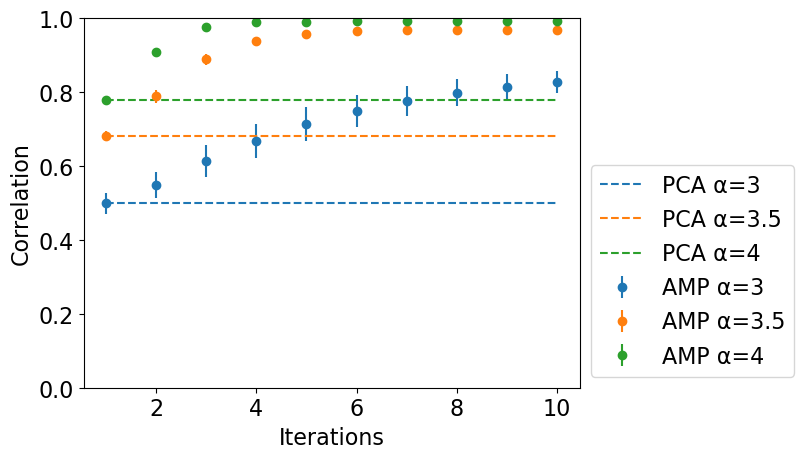

In [24]:
create_scal_over_iterations_graph(data_performance, "tanh", legend_loc="lower left", filename="rademacher_mp_n4000_trial50")

In [29]:
data_performance_unif = symmetric_unif_exp(rademacher, 4000, [0.2, 0.4, 0.6], 50, 10, ["tanh"])

Starting Experiment: Symmetric AMP with Unif noise
Trial 1, alpha 0.2, tanh denoiser
Iteration 1, scal=0.14992698355486178
Iteration 2, scal=0.15129648977829327
Iteration 3, scal=0.15398146773213867
Iteration 4, scal=0.15245743368367107
Iteration 5, scal=0.1438118557424991
Iteration 6, scal=0.13195081791633737
Iteration 7, scal=0.12057490882937139
Iteration 8, scal=0.09918362672380275
Iteration 9, scal=0.06427144235816588
Iteration 10, scal=0.028167538554749478
Trial 1, alpha 0.4, tanh denoiser
Iteration 1, scal=0.6012009984931048
Iteration 2, scal=0.6381852760850084
Iteration 3, scal=0.6922449997948089
Iteration 4, scal=0.6955707683854716
Iteration 5, scal=0.6868835111597319
Iteration 6, scal=0.6861472799645347
Iteration 7, scal=0.6897340984344025
Iteration 8, scal=0.6903169860278445
Iteration 9, scal=0.689321082068332
Iteration 10, scal=0.6892293574092909
Trial 1, alpha 0.6, tanh denoiser
Iteration 1, scal=0.7982439693495322
Iteration 2, scal=0.8897993239259869
Iteration 3, scal=0.93

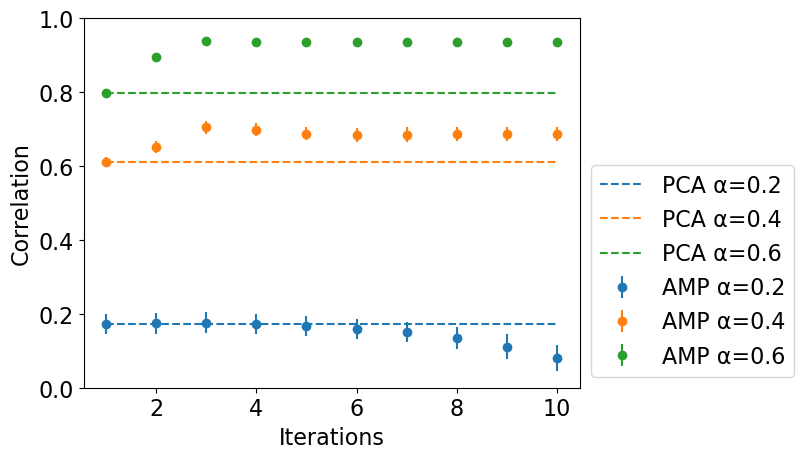

In [30]:
create_scal_over_iterations_graph(data_performance_unif, "tanh", legend_loc="lower left", filename="rademacher_unif_n4000_trial50")

In [31]:
data_performance_test = symmetric_mp_exp(test, 4000, [3, 4], 50, 10, ["tanh"])

Starting Experiment: Symmetric AMP with M-P noise
Trial 1, alpha 3, tanh denoiser
Iteration 1, scal=0.528532946683891
Iteration 2, scal=0.5420250929699909
Iteration 3, scal=0.5730301972340024
Iteration 4, scal=0.5878505597393991
Iteration 5, scal=0.5933504381306397
Iteration 6, scal=0.5948039502474997
Iteration 7, scal=0.5948290959376452
Iteration 8, scal=0.5937895664521768
Iteration 9, scal=0.591922936537419
Iteration 10, scal=0.5898734538885619
Trial 1, alpha 4, tanh denoiser
Iteration 1, scal=0.7737019315701421
Iteration 2, scal=0.7624824102338817
Iteration 3, scal=0.7881821146779513
Iteration 4, scal=0.7954735539023562
Iteration 5, scal=0.7985322909697197
Iteration 6, scal=0.8002790941379135
Iteration 7, scal=0.8011685482279151
Iteration 8, scal=0.8013634433041936
Iteration 9, scal=0.8012636265254345
Iteration 10, scal=0.8011034867678916
Trial 2, alpha 3, tanh denoiser
Iteration 1, scal=0.4990671615531289
Iteration 2, scal=0.513715720274687
Iteration 3, scal=0.5543374848323794
Iter

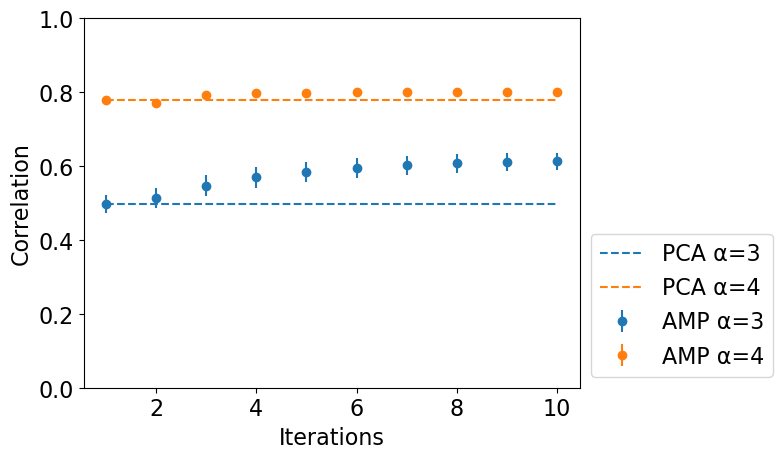

In [32]:
create_scal_over_iterations_graph(data_performance_test, "tanh", legend_loc="lower left", filename="3label_mp_n4000_trial50")